NOTE: This is unfinished. It includes experiments on SGD and SGD w/ momentum, but not Adam.

# Run your own set of noisy quadratic model experiments.

In [1]:
import torch
from matplotlib import pyplot as plt
import seaborn as sns

# Set up a testbed using the setup from the NQM paper, where the covariance matrix of the gradient and the Hessian are both diagonal. You can use the same defaults for these matrices as in the paper, i.e., diagonal entries of 1, 1/2, 1/3, ... for both (in the paper they go up to 10^4, you can reduce this to 10^3 if experiments are taking too long to run). Implement both SGD with momentum and Adam.

SGD

In [2]:
def loss(h, s):
    return 0.5 * torch.sum(h * s)

In [3]:
def simulate_k_steps(h, sigma_sq, s_init, alpha: float, k: int):
    beta = (1 - alpha*h) ** 2
    s_star = alpha**2 * sigma_sq / (1 - beta + 1e-8)
    return s_star + beta ** k * (s_init - s_star)

In [4]:
def min_time_to_loss(h, sigma_sq, s_init, alpha: float, target_loss: float):
    left, right = 0, 2**20
    min_steps = float('inf')
    while left <= right:
        mid = (left + right) // 2
        s_k = simulate_k_steps(h, sigma_sq, s_init, alpha, k=mid)
        loss_k = loss(h, s_k)
        if loss_k <= target_loss:
            min_steps = mid
            right = mid - 1
        else:
            left = mid + 1
    return min_steps

SGD w/ momentum

In [7]:
def simulate_momentum_dynamics(h, sigma_sq, s_init, lrate, k, momentum=0.0):
    ndim = h.shape[0]
    
    init_p = torch.zeros((ndim, 3))
    init_p[:, 0] = s_init
    
    x = lrate*h
    noise = ((lrate)**2 * sigma_sq).unsqueeze(-1).expand(ndim, 3)
    
    # defining the transition matrix (see eqn.(21) in the paper)
    trans_mat = torch.zeros((ndim, 3, 3))
    trans_mat[:, :, 1] = momentum ** 2
    trans_mat[:, 0, 0] = (1 - x) ** 2
    trans_mat[:, 1, 0] = x ** 2
    trans_mat[:, 2, 0] = - (1 - x) * x
    trans_mat[:, 0, 2] = 2 * (1 - x) * momentum
    trans_mat[:, 1, 2] = -2 * x * momentum
    trans_mat[:, 2, 2] = (1 - 2 * x) * momentum
    
    # eigen-decomposition
    e, v = torch.linalg.eig(trans_mat)
    v_inv = torch.linalg.inv(v)
    
    trans_init_p = torch.matmul(v_inv, init_p.unsqueeze(-1).type(torch.complex64)).squeeze()
    trans_noise = torch.matmul(v_inv, noise.unsqueeze(-1).type(torch.complex64)).squeeze()
    
    p_star = trans_noise / (1 - e)
    
    trans_final_p = e ** k * (trans_init_p - p_star) + p_star
    final_p = torch.matmul(v, trans_final_p.unsqueeze(-1)).squeeze()
    return final_p[:, 0].real

In [10]:
def time_to_loss_wm(h, sigma_sq, s_init, lrate, momentum, C):
    high = 10000000
    low = 0
        
    while low < high - 1:
        mid = (low + high) // 2
            
        s = simulate_momentum_dynamics(h, sigma_sq, s_init, lrate, mid, momentum=momentum)
        L = loss(h, s)
        if L < C:
            high = mid
        else:
            low = mid
        
    return low

# Create a method for optimizing learning rate schedules. You can either use dynamic programming using equation (3) as in the paper (see footnote on page 7), or a simpler empirical method such as black-box optimization (perhaps with simpler schedule).

In [11]:
def simulate_dynamics_lr_sched(h, sigma_sq, s_init, lrates, ks):
    s = s_init
    for lrate, k in zip(lrates, ks):
        s = simulate_k_steps(h, sigma_sq, s, lrate, k)
    return s

In [12]:
def loss_lr_sched(h, sigma_sq, s_init, log_lrates, ks):
    s = simulate_dynamics_lr_sched(h, sigma_sq, s_init, torch.exp(log_lrates), ks)
    return loss(h, s)

In [13]:
def optimize_lrates(h, sigma_sq, s_init, ks):
    num_pieces = ks.shape[0]
    log_lrs = -1 * torch.ones(num_pieces)
    log_lrs.requires_grad = True

    optimizer = torch.optim.LBFGS([log_lrs], max_iter=10)
    num_iters = 10
    for _ in range(num_iters):
        optimizer.zero_grad()
        loss = loss_lr_sched(h, sigma_sq, s_init, log_lrs, ks)
        loss.backward()
        optimizer.step(lambda: loss_lr_sched(h, sigma_sq, s_init, log_lrs, ks))
    
    return log_lrs

In [14]:
def min_ttl_sched(h, sigma_sq, s_init, target_loss, num_pieces):
    left, right = 0, 2**20
    min_steps_per_piece = float('inf')
    best_llr_sched = None
    while left <= right:
        mid = (left + right) // 2
        ks = mid * torch.ones(num_pieces)
        log_lrates = optimize_lrates(h, sigma_sq, s_init, ks)
        s = simulate_dynamics_lr_sched(h, sigma_sq, s_init, torch.exp(log_lrates), ks)
        L = loss(h, s)
        if L <= target_loss:
            min_steps_per_piece = mid
            best_llr_sched = log_lrates
            right = mid - 1
        else:
            left = mid + 1

    return min_steps_per_piece, torch.exp(best_llr_sched)

In [15]:
# copy plt settings from paper
plt.style.use('classic')
def init_plotting():
    plt.rcParams['figure.figsize'] = (10, 7)
    plt.rcParams['pdf.fonttype'] = 42
    plt.rcParams['font.size'] = 18
    plt.rcParams['axes.labelsize'] = 1.5 * plt.rcParams['font.size']
    plt.rcParams['axes.titlesize'] = 1.5 * plt.rcParams['font.size']
    plt.rcParams['axes.grid']=  True
    plt.rcParams['legend.fontsize'] = 1.2 * plt.rcParams['font.size']
    plt.rcParams['xtick.labelsize'] = 1.2 * plt.rcParams['font.size']
    plt.rcParams['ytick.labelsize'] = 1.2 * plt.rcParams['font.size']
    plt.rcParams["legend.framealpha"] = 0.7
    plt.rcParams['lines.linewidth'] = 3.0
    plt.rcParams['lines.markersize'] = 10

sns.set()
init_plotting()

colors = ["r", "g", "b", "c"]

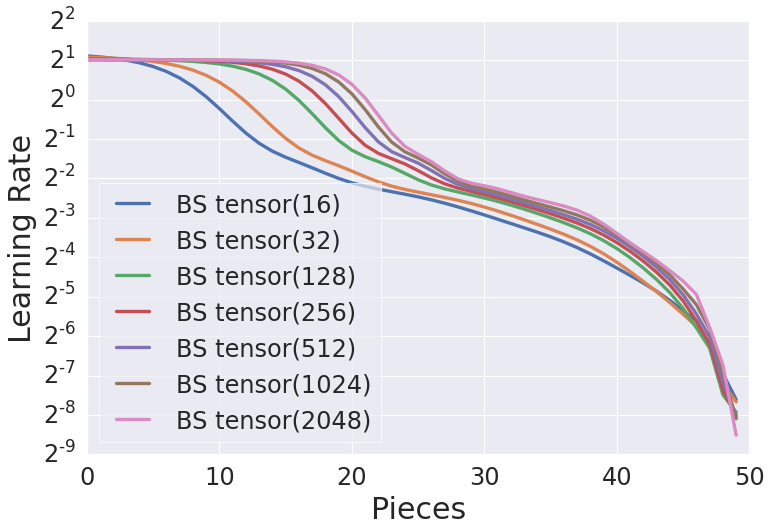

In [16]:
batch_sizes = 2 ** torch.arange(4, 12)

ndim = 10**3
h = 1.0 / torch.arange(1, ndim+1)
s_init = torch.ones(ndim)
target_loss = 0.01

for i, bs in enumerate(batch_sizes):
  sigma_sq = h / bs
  _, lrates = min_ttl_sched(h, sigma_sq, s_init, target_loss, num_pieces=50)
  if bs.item() != 64: # TODO: figure out what's wrong with bs=64
    plt.semilogy(lrates.detach().numpy(), label="BS " + str(bs), basey=2)
plt.xlabel('Pieces')
plt.ylabel('Learning Rate')
plt.ylim(ymax=4)
plt.tight_layout()
plt.legend(loc=3);

# Check that at very small batch sizes, the optimal learning rate scales with batch size as expected: proportional to the batch size for SGD, proportional to the square root of the batch size for Adam.

SGD

In [17]:
def grid_search_lr(h, sigma_sq, s_init, target_loss):
    lrs = torch.logspace(-5, 0.5, 100)

    min_steps = float('inf')
    best_lr = None
    for lr in lrs:
        num_steps = min_time_to_loss(h, sigma_sq, s_init, lr, target_loss)
        if num_steps < min_steps:
            min_steps = num_steps
            best_lr = lr
    
    return min_steps, best_lr

In [18]:
batch_sizes = [2 ** i for i in range(2, 22)]

ndim = 10**3
h = 1.0 / torch.arange(1, ndim+1)
s_init = torch.ones(ndim)
target_loss = 0.1

num_steps = []
optimal_lrs = []

for bs in batch_sizes:
    sigma_sq = h / bs
    steps_to_target, optimal_lr = grid_search_lr(h, sigma_sq, s_init, target_loss)
    num_steps.append(steps_to_target)
    optimal_lrs.append(optimal_lr)

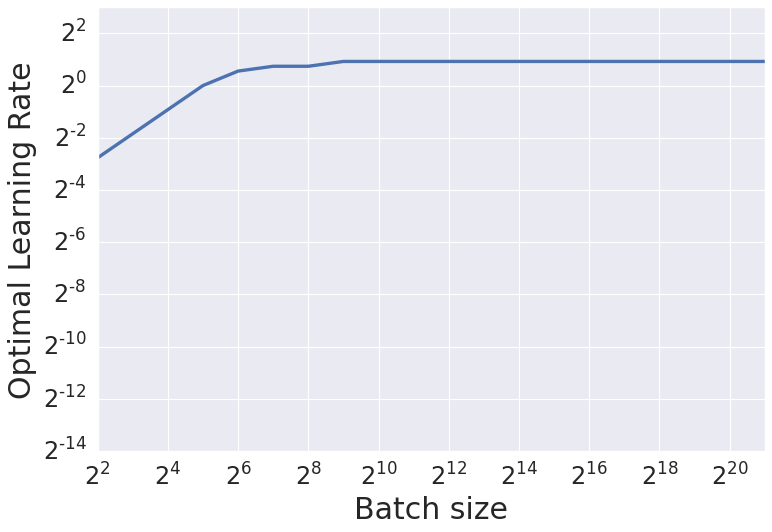

In [19]:
plt.loglog(batch_sizes, optimal_lrs, basex=2, basey=2)
plt.ylim(2 ** (-14), 2 ** 3)
plt.xlabel("Batch size")
plt.ylabel("Optimal Learning Rate")
plt.tight_layout()

SGD w/ momentum

In [20]:
def grid_search_lr_wm(h, sigma_sq, s_init, C, momentum=None):
    lrates = torch.logspace(-8, 1, 100)
    
    if momentum is None:
        momentums = 1 - torch.logspace(-5, 0, 20)
    else:
        momentums = [momentum]
    best = float('inf')
    best_lrate = 0.0
    best_momentum = 0.0
    for lrate in lrates:
        for momentum in momentums:
            ttl = time_to_loss_wm(h, sigma_sq, s_init, lrate, momentum, C)
            if ttl < best:
                best = ttl
                best_lrate = lrate
                best_momentum = momentum
    return best, best_lrate, best_momentum

In [ ]:
batch_sizes = [2 ** i for i in range(2, 22)]

ndim = 10**3
h = 1.0 / torch.arange(1, ndim+1)
s_init = torch.ones(ndim)
target_loss = 0.1

num_steps_wm = []
optimal_lrs_wm = []

for bs in batch_sizes:
    sigma_sq = h / bs
    steps_to_target, optimal_lr, _ = grid_search_lr_wm(h, sigma_sq, s_init, target_loss)
    num_steps_wm.append(steps_to_target)
    optimal_lrs_wm.append(optimal_lr)

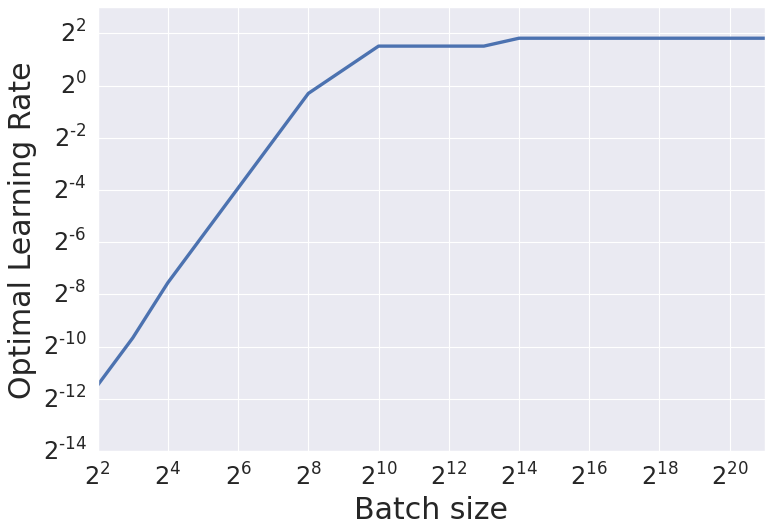

In [22]:
plt.loglog(batch_sizes, optimal_lrs_wm, basex=2, basey=2)
plt.ylim(2 ** (-14), 2 ** 3)
plt.xlabel("Batch size")
plt.ylabel("Optimal Learning Rate")
plt.tight_layout()

# Look at the relationship between the batch size and the number of steps to reach a target loss. Study the effects of momentum and using Adam on this relationship.

SGD

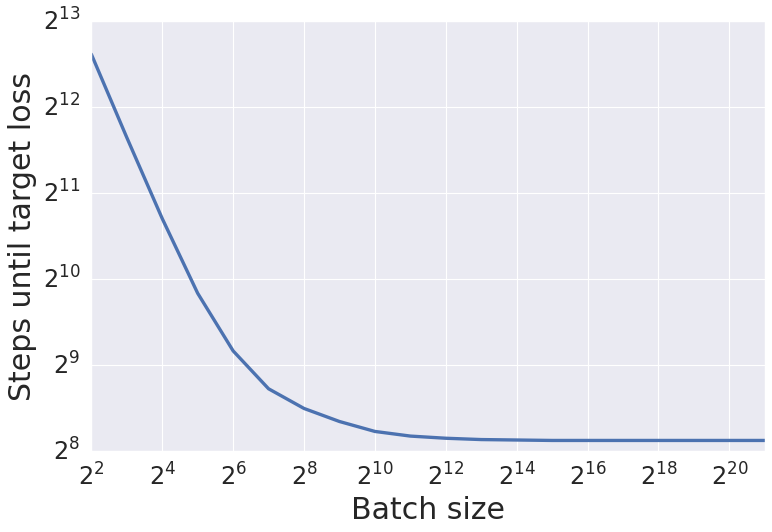

In [23]:
plt.loglog(batch_sizes, num_steps, basex=2, basey=2)
plt.xlabel("Batch size")
plt.ylabel("Steps until target loss")
plt.tight_layout()

SGD w/ momentum

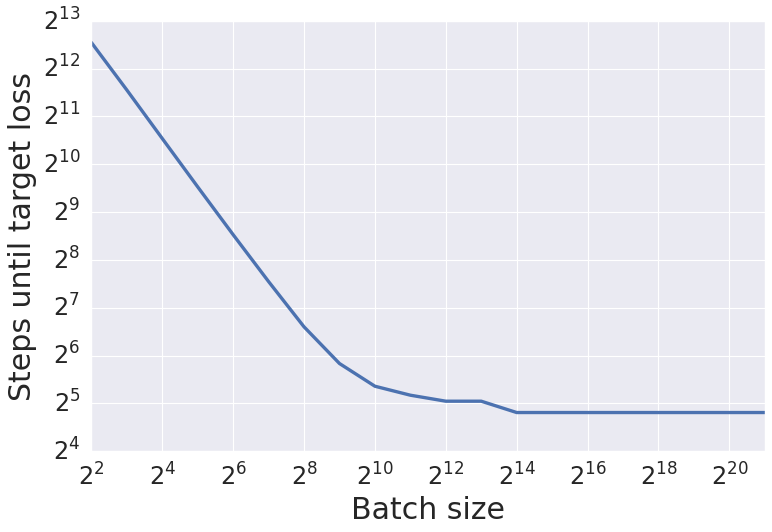

In [24]:
plt.loglog(batch_sizes, num_steps_wm, basex=2, basey=2)
plt.xlabel("Batch size")
plt.ylabel("Steps until target loss")
plt.tight_layout()